# Réseau de neurone ``PyTorch``- Prédiction de vainqueur sur StarCraft 2

Le dataset représente de nombreuses parties 1 contre 1 sur le jeu StarCraft 2.
Pour chaque replay est enregistré à chaque temps T l'etat du jeu (26 champs) ainsi que le vainqueur (1 champ), indiqué en dernière colonne par 0 ou 1.

<img src="files/figures/sc2_logo.png" width="600px"/>

Nous définirons et entraînerons un réseau de neurones sur ce dataset. C'est un problème de régression car nous voulons une probabilité de victoire.<br>
Nous commencerons par programmer notre réseau de neurones en affichant les données pertinentes, et nous passerons à une étude de cas pour concrétiser l'utilisation du programme.

## 1. Librairies

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset, random_split

## 2. Exploration des datasets

- L'étape la plus longue pour arriver à entraîner notre IA a consisté en l'élaboration d'un dataset de qualité pour le sujet qui nous intéressait. Nous avons dû écrire un programme permettant de générer un grand nombre de rows (lignes) sur de nombreuses données permettant de décrire l'état d'une partie de StarCraft 2 en cours.<br>
Le code source de ce parseur est disponible sur github :<br>
https://github.com/YannBgit/SC2replayDatasetGenerator

- Ce programme a pu être écrit grâce à l'API sc2reader qui permet d'extraire des données de fichiers SC2Replay. Son code source est également disponible :<br>
https://github.com/ggtracker/sc2reader

- Le parseur contient des fonctionnalités d'ergonomie et de randomisation de datasets. Sans entrer dans les détails (l'utilisation est détaillée dans le README), il est possible à partir d'un répertoire contenant un grand nombre de replays de choisir le nombre à utiliser pour le dataset, qu'un script va sélectionner aléatoirement dans le répertoire source.<br>
- Le parseur va ensuite extraire des données de ces replays pour générer un grand nombre de rows correspondant chacun à un instant dans la partie étudiée.<br><br>
- L'étape suivante a été de trouver un grand nombre de replays exploitables à donner au parseur. Heureusement, Blizzard, le studio produisant le jeu, a rendu public une base de données massive de replays anonymisés qui ont servi aux équipes de Google pour entraîner l'IA AlphaStar. Nous avons donc pu raisonnablement parser 30 000 replays.
- Affichage des données.

In [2]:
data = pd.read_csv("archive/shuffledDataset.csv")
data.head(3)

,time,race1,race2,map,supplyUsed1,supplyUsed2,totalIncome1,totalIncome2,mineralsIncome1,mineralsIncome2,...,vespene2,activeWorkers1,activeWorkers2,army1,army2,technology1,technology2,lostResources1,lostResources2,winner
0,1014,0,1,18,65.0,113.0,224,1048,0,680,...,659,13,33,3200,4875,1575,1300,10006,9762,0
1,914,2,2,8,148.0,104.0,2040,2224,1320,1600,...,223,73,68,6325,3325,4250,3650,12075,15625,0
2,593,0,0,16,85.0,75.0,3403,1482,2799,1147,...,1061,56,30,1325,2875,2400,1725,2772,1900,0


In [3]:
data.dtypes

time                 int64
race1                int64
race2                int64
map                  int64
supplyUsed1        float64
supplyUsed2        float64
totalIncome1         int64
totalIncome2         int64
mineralsIncome1      int64
mineralsIncome2      int64
vespeneIncome1       int64
vespeneIncome2       int64
totalResources1      int64
totalResources2      int64
minerals1            int64
minerals2            int64
vespene1             int64
vespene2             int64
activeWorkers1       int64
activeWorkers2       int64
army1                int64
army2                int64
technology1          int64
technology2          int64
lostResources1       int64
lostResources2       int64
winner               int64
dtype: object

In [4]:
len(data.index)

1738665

In [5]:
len(data.columns)

27

In [6]:
data.race1.value_counts()

1    642765
0    596761
2    499139
Name: race1, dtype: int64

- Visualisation des relations entre les colonnes.

<AxesSubplot:>

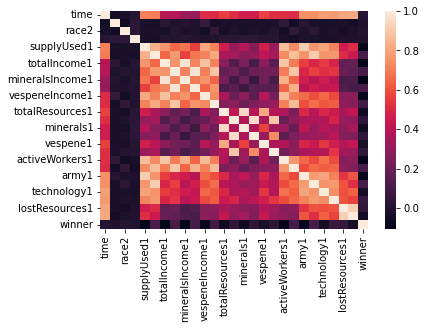

In [7]:
sns.heatmap(data.corr())

## 3. Chargement des données

- Création des ensembles d'entraînement, d'évaluation et de test. <br>
A noter que le préprocessing a été géré par le parseur en amont. Seuls des nombres (int ou float) sont écrits dans les colonnes.

In [8]:
def dataToArrays(data, columns):
    dataCopy = data.copy(deep = True)
    
    #normalisation des données
    for column in columns:
        dataCopy[column] = (dataCopy[column] - dataCopy[column].min()) / (dataCopy[column].max() - dataCopy[column].min())
            
    inputArray = dataCopy[columns].to_numpy()
    outputArray = dataCopy[outputColumns].to_numpy().reshape(-1, 1)
    return inputArray, outputArray

In [9]:
inputColumns = [title for title in data.columns if title != "winner"]
outputColumns = ["winner"]

inputArray, outputArray = dataToArrays(data, inputColumns)

inputs = torch.tensor(inputArray, dtype = torch.float32)
outputs = torch.tensor(outputArray, dtype = torch.float32)

dataset = TensorDataset(inputs, outputs)

validationSize = int(0.2 * len(dataset))
trainSize = len(dataset) - validationSize
trainDataset, validationDataset = random_split(dataset, [trainSize, validationSize])

## 4. Dataloaders

In [10]:
batchSize = 64

trainLoader = DataLoader(trainDataset, batchSize, shuffle = True)
validationLoader = DataLoader(validationDataset, batchSize, shuffle = True)

nbInputs = len(inputColumns)
nbOutputs = 1

- Définition de la fonction de calcul de précision.

In [11]:
def accuracy(outputs, labels):
    #prediction = 1 si output > 0.5 et prediction = 0 sinon
    return torch.tensor(torch.sum(outputs.round() == labels).item() / len(outputs))

## 5. Modèle

- Définition du modèle. La fonction sigmoid en dernière couche permet d'avoir en output une valeur comprise entre 0 et 1

In [12]:
layerSize = 128

class Model(nn.Module):
    def __init__(self):
        super().__init__()        
        self.fc1 = nn.Linear(nbInputs, layerSize)
        self.fc2 = nn.Linear(layerSize, layerSize)
        self.fc3 = nn.Linear(layerSize, nbOutputs)
        
    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        
        x = self.fc2(x)
        x = nn.ReLU()(x)
        
        x = self.fc3(x)
        return torch.sigmoid(x)
    
    def trainingStep(self, batch):
        inputs, labels = batch 
        out = self(inputs)
        currentLoss = F.binary_cross_entropy(out, labels)
        return currentLoss
    
    def validationStep(self, batch):
        inputs, labels = batch
        out = self(inputs)
        currentLoss = F.binary_cross_entropy(out, labels)
        currentAccuracy = accuracy(out, labels)
        return {"Validation loss" : currentLoss, "Validation accuracy" : currentAccuracy}
    
    def validationEpochEnd(self, outputs):
        batchLosses = [x["Validation loss"] for x in outputs]
        epochLoss = torch.stack(batchLosses).mean()
        batchAccuracy = [x["Validation accuracy"] for x in outputs]
        epochAccuracy = torch.stack(batchAccuracy).mean()
        return {"Validation loss" : epochLoss.item(), "Validation accuracy" : epochAccuracy.item()}
    
    def epochEnd(self, epoch, result):
        print("Epoch [{}], Validation loss : {:.4f}, Validation accuracy : {:.4f}".format(epoch, result["Validation loss"], result["Validation accuracy"]))
    
model = Model()

- Affichage des paramètres du modèle.

In [13]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1693, -0.1939, -0.1488,  ...,  0.1091,  0.0045,  0.0706],
         [-0.1958, -0.0837, -0.0086,  ..., -0.0480, -0.0912,  0.1751],
         [ 0.1053,  0.0699, -0.1850,  ...,  0.1734,  0.0827,  0.0510],
         ...,
         [ 0.0171, -0.0463, -0.1432,  ...,  0.1496,  0.1826,  0.0023],
         [ 0.1773, -0.1426,  0.0968,  ...,  0.1667, -0.1864,  0.1892],
         [ 0.1918,  0.1698,  0.1794,  ..., -0.1027, -0.1033,  0.0352]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.1162, -0.1919,  0.1095, -0.1574,  0.0206,  0.1527,  0.0723,  0.0971,
          0.1074, -0.1262,  0.1606, -0.0777,  0.1405,  0.0314, -0.0277, -0.1242,
          0.1266,  0.0886,  0.1054,  0.1556, -0.1882,  0.0343,  0.1648, -0.0467,
         -0.1022, -0.1512, -0.0165, -0.0620,  0.1349, -0.1824, -0.0321,  0.1910,
         -0.1232, -0.1419,  0.0833, -0.1351, -0.0165,  0.1099, -0.1881,  0.1726,
          0.0787,  0.0876,  0.1166,  0.1379, -0.0768, -0.1284,  0.1702,  0.0692

## 6. Entraînement

In [14]:
@torch.no_grad()
def evaluate(model, validationLoader):
    model.eval()
    outputs = [model.validationStep(batch) for batch in validationLoader]
    return model.validationEpochEnd(outputs)

def test(model, testLoader):
    model.eval()
    outputs = [model.validationStep(batch) for batch in testLoader]
    return model.validationEpochEnd(outputs)

def fitOneCycle(epochs, learningRate, model, trainLoader, validationLoader):
    history = []
    
    optimizer = torch.optim.SGD(model.parameters(), learningRate)
    
    for epoch in range(epochs):
        model.train()
        trainLosses = []
        
        for batch in trainLoader:
            loss = model.trainingStep(batch)
            trainLosses.append(loss)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, validationLoader)
        result["Train loss"] = torch.stack(trainLosses).mean().item()
        model.epochEnd(epoch, result)
        history.append(result)
    
    return history

- Paramétrage et entraînement du réseau de neurones.

In [15]:
history = [evaluate(model, validationLoader)]

nbEpochs = 10
learningRate = 0.001

history += fitOneCycle(nbEpochs, learningRate, model, trainLoader, validationLoader)

Epoch [0], Validation loss : 0.6901, Validation accuracy : 0.5264
Epoch [1], Validation loss : 0.6878, Validation accuracy : 0.5283
Epoch [2], Validation loss : 0.6828, Validation accuracy : 0.5600
Epoch [3], Validation loss : 0.6706, Validation accuracy : 0.6026
Epoch [4], Validation loss : 0.6436, Validation accuracy : 0.6409
Epoch [5], Validation loss : 0.6137, Validation accuracy : 0.6522
Epoch [6], Validation loss : 0.5987, Validation accuracy : 0.6568
Epoch [7], Validation loss : 0.5921, Validation accuracy : 0.6611
Epoch [8], Validation loss : 0.5885, Validation accuracy : 0.6631
Epoch [9], Validation loss : 0.5860, Validation accuracy : 0.6652


- Définition des fonctions d'affichage de l'accuracy et de la loss

In [16]:
def plotAccuracies(history):
    accuracies = [x["Validation accuracy"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy / Number of epochs");

def plotLosses(history):
    trainLosses = [x.get("Train loss") for x in history]
    valLosses = [x["Validation loss"] for x in history]
    plt.plot(trainLosses, "-bx")
    plt.plot(valLosses, "-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss / Number of epochs");

- Graphique de l'évolution de l'accuracy par rapport au numéro de l'epoch.

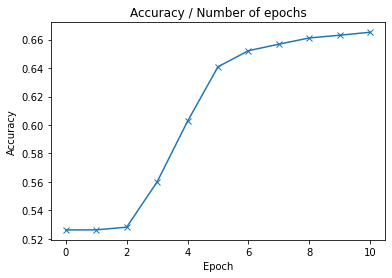

In [17]:
plotAccuracies(history)

- Graphique de l'évolution de la loss par rapport au numéro de l'epoch.

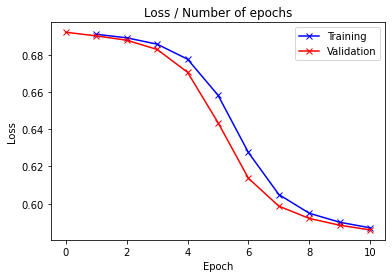

In [18]:
plotLosses(history)

In [19]:
result = evaluate(model, validationLoader)
print(result)

{'Validation loss': 0.5859730839729309, 'Validation accuracy': 0.6651454567909241}


## 7. Tests

- Test du modèle sur le test set parsé par le générateur de datasets décrit au début de ce notebook. Sa taille est de 20 % la taille du dataset original (avant séparation en train set et validation set).

In [20]:
testData = pd.read_csv("archive/testDataset.csv")

inputTestArray, outputTestArray = dataToArrays(testData, inputColumns)

testInputs = torch.tensor(inputTestArray, dtype = torch.float32)
testOutputs = torch.tensor(outputTestArray, dtype = torch.float32)

testDataset = TensorDataset(testInputs, testOutputs)
testLoader = DataLoader(testDataset, batchSize, shuffle = True)

nbTestInputs = len(inputColumns)
nbTestOutputs = 1

testHistory = [test(model, testLoader)]
print(testHistory)

[{'Validation loss': 0.5868923664093018, 'Validation accuracy': 0.6645539402961731}]


- Explications :<br>
Notre accuracy est d'environ 0.67, ce qui, bien que meilleur que l'aléatoire de 0.50, reste bas. Ce constat s'explique cependant simplement. En effet, pour une bonne partie de la durée des replays étudiés, il est difficile de prévoir quel joueur va gagner. Par exemple, en début de partie, peu de choses se passent et les joueurs se contentent bien souvent de développer leur économie, ne laissant pas de joueur obtenir un quelconque avantage sur l'autre.<br>
Nous pouvons en revanche nous attendre à de bonne performances une fois que des batailles commencent à se dérouler, et de manière générale lorsque la partie se rapproche de la fin.<br>
Ces cas seront clairement expliqués lors de l'étude de cas plus bas.
- Définition de la fonction de prédiction utilisant le réseau de neurones entraîné.

In [21]:
def predict(input, verbose = True):
    if verbose:
        for i in range(len(inputColumns)):
            tmp = input[0][i].item()
            tmp = round(tmp * (data[inputColumns[i]].max() - data[inputColumns[i]].min()) + data[inputColumns[i]].min(), 4)
            print(inputColumns[i] + ":", tmp)
            
        print("")
    
    with torch.no_grad():
        pred = model(input[0]).item()
        
    print("Probabilité de victoire du joueur 1 : {:.4f}".format(1 - pred))

- Quelques prédictions.

In [22]:
predict(validationDataset[256])

time: 236.0
race1: 1.0
race2: 1.0
map: 5.0
supplyUsed1: 49.0
supplyUsed2: 50.0
totalIncome1: 1863.0001
totalIncome2: 1494.0
mineralsIncome1: 1706.9999
mineralsIncome2: 1315.0
vespeneIncome1: 156.0
vespeneIncome2: 179.0
totalResources1: 389.0
totalResources2: 172.0
minerals1: 255.0
minerals2: 40.0
vespene1: 134.0
vespene2: 132.0
activeWorkers1: 35.0
activeWorkers2: 29.0
army1: 800.0
army2: 1100.0
technology1: 450.0
technology2: 250.0
lostResources1: 0.0
lostResources2: 0.0

Probabilité de victoire du joueur 1 : 0.5852


In [23]:
predict(validationDataset[512])

time: 214.0
race1: 2.0
race2: 1.0
map: 8.0
supplyUsed1: 44.0
supplyUsed2: 45.0
totalIncome1: 1886.0001
totalIncome2: 1634.0
mineralsIncome1: 1595.0
mineralsIncome2: 1455.0
vespeneIncome1: 291.0
vespeneIncome2: 179.0
totalResources1: 132.0
totalResources2: 313.0
minerals1: 55.0
minerals2: 229.0
vespene1: 77.0
vespene2: 84.0
activeWorkers1: 36.0
activeWorkers2: 34.0
army1: 300.0
army2: 600.0
technology1: 600.0
technology2: 250.0
lostResources1: 0.0
lostResources2: 0.0

Probabilité de victoire du joueur 1 : 0.5671


## 8. Etude de cas pratiques

- Changeons de dataset pour utiliser notre fichier contenant 4 moments notables pour 2 parties différentes (soit 8 rows).

In [24]:
dataPrime = pd.read_csv("archive/datasetPrime.csv")
dataPrime.head(len(dataPrime.index))

,time,race1,race2,map,supplyUsed1,supplyUsed2,totalIncome1,totalIncome2,mineralsIncome1,mineralsIncome2,...,vespene2,activeWorkers1,activeWorkers2,army1,army2,technology1,technology2,lostResources1,lostResources2,winner
0,100,2,0,0,20.0,20.0,1040,883,951,727,...,34,20,19,0,0,150,150,0,0,1
1,621,2,0,0,133.0,166.0,3655,3566,2827,2603,...,284,64,72,4325,5200,2750,3375,3300,2124,1
2,643,2,0,0,86.0,151.0,3498,3431,2715,2491,...,478,64,71,600,4450,3550,3575,7625,3799,1
3,721,2,0,0,79.0,170.0,3090,4109,2127,2967,...,762,65,73,175,5675,3150,4125,12450,5624,1
4,100,1,0,1,20.0,20.0,911,962,867,783,...,38,18,19,0,0,0,150,0,0,1
5,493,1,0,1,149.0,128.0,4574,2899,3723,2183,...,631,90,61,3650,4675,1700,2000,1043,0,1
6,507,1,0,1,110.0,121.0,4562,2966,3667,2183,...,294,90,61,1550,3325,2150,2000,3418,1300,1
7,779,1,0,1,94.0,167.0,2994,3252,2323,2491,...,378,72,58,750,5950,2025,3475,15328,10175,1


In [25]:
def predictor(n):
    toPredict = list()
    
    for i in range(len(inputColumns)):
        toPredict.append(dataPrime.iloc[n][i])
    
    toPredict = [float(item) for item in toPredict]
    
    for col in range(len(inputColumns)):
        toPredict[col] = (toPredict[col] - data[inputColumns[col]].min()) / (data[inputColumns[col]].max() - data[inputColumns[col]].min())
    
    predict(torch.tensor([toPredict], dtype = torch.float32), verbose = False)

- Rappelons que "joueur 1" désigne le joueur décrit par "race1", "supplyUsed1...". Les captures d'écran sont prises du point de vue du joueur 1 (Protoss dans la partie 1 et Zerg dans la partie 2).
- 1ère partie à 1 min 40 (début de partie). On remarque que la probabilité de victoire du joueur est quasiment de 49 % (ou 49/100 = 0.5), en équilibre avec la probabilité de victoire de l'adversaire.

<img src="files/figures/TvP1.jpg" width="800px"/>

In [26]:
predictor(0)

Probabilité de victoire du joueur 1 : 0.4840


- 1ère partie à 10 min 21 (avant le combat). Le réseau de neurones prédit une mauvaise bataille pour le joueur Protoss. Sa probabilité que la partie se solde par une victoire pour lui est estimée à 20 %.

<img src="files/figures/TvP2.jpg" width="800px"/>

In [27]:
predictor(1)

Probabilité de victoire du joueur 1 : 0.2295


Image du déroulé du combat à titre indicatif.

<img src="files/figures/TvP3.jpg" width="800px"/>

- 1ère partie à 10 min 43 (après le combat). Après la destruction de son armée, les chances de victoire du joueur Protoss baissent encore pour atteindre environ 9 %.

<img src="files/figures/TvP4.jpg" width="800px"/>

In [28]:
predictor(2)

Probabilité de victoire du joueur 1 : 0.1052


- 1ère partie à 12 min 01 (fin de partie). Juste avant que le joueur n'abandonne, le réseau de neurones ne donne plus que 3 % de chances de victoire au joueur Protoss.

<img src="files/figures/TvP5.jpg" width="800px"/>

In [29]:
predictor(3)

Probabilité de victoire du joueur 1 : 0.0363


- 2ème partie à 1 min 40 (début de partie). Encore une fois, la situation des deux joueurs est relativement équivalente à ce moment de la partie avec une chance de victoire de 46 % pour le joueur Zerg. Cet écart intéressant (malgré tout faible) peut témoigner soit d'erreurs faites par le joueur en ce début de partie, soit d'un déséquilibre comme une carte favorable au joueur Terran (adverse).

<img src="files/figures/TvZ1.jpg" width="800px"/>

In [30]:
predictor(4)

Probabilité de victoire du joueur 1 : 0.4505


- 2ème partie à 8 min 13 (avant le combat). Le réseau de neurones prédit une victoire du joueur Zerg avec 85 % de probabilité.

<img src="files/figures/TvZ2.jpg" width="800px"/>

In [31]:
predictor(5)

Probabilité de victoire du joueur 1 : 0.8454


Image du déroulé du combat à titre indicatif.

<img src="files/figures/TvZ3.jpg" width="800px"/>

- 2ème partie à 8 min 27 (après le combat). La prédiction précédente se trouve déjouée par le joueur Terran qui a pris un meilleur engagement pour diverses raisons. Malgré tout, le joueur Zerg conserve de bonnes chances de gagner de 73 % grâce notamment à son économie (il possède 4 bases contre 3 pour le joueur Terran).

<img src="files/figures/TvZ4.jpg" width="800px"/>

In [32]:
predictor(6)

Probabilité de victoire du joueur 1 : 0.7074


- 2ème partie à 12 min 59 (fin de partie). Le joueur Zerg n'aura pas su tirer parti de son économie. On observe en effet à la fin de la partie qu'il possède beaucoup de ressources en réserve (indiquées sur le bord supérieur droit de l'image ci-dessous). Les ressources qu'il a récolté n'ont pas été réinvesties, conduisant à une probabilité de victoire de 8 % avant son abandon.

<img src="files/figures/TvZ5.jpg" width="800px"/>

In [33]:
predictor(7)

Probabilité de victoire du joueur 1 : 0.0844


## Sauvegarde

In [34]:
torch.save(model.state_dict(), "starcraft2-best-model.pt")
print(model.state_dict())

OrderedDict([('fc1.weight', tensor([[-0.1733, -0.1966, -0.1567,  ...,  0.1054,  0.0024,  0.0706],
        [-0.1958, -0.0837, -0.0086,  ..., -0.0480, -0.0912,  0.1751],
        [ 0.0993,  0.0795, -0.1223,  ...,  0.1402,  0.0682,  0.0754],
        ...,
        [ 0.0171, -0.0460, -0.1436,  ...,  0.1491,  0.1827,  0.0025],
        [ 0.1812, -0.1348,  0.1041,  ...,  0.1694, -0.1853,  0.1879],
        [ 0.2061,  0.1787,  0.1663,  ..., -0.0541, -0.0807,  0.0042]])), ('fc1.bias', tensor([ 0.0780, -0.1919,  0.1687, -0.1604,  0.0576,  0.1459,  0.0839,  0.1477,
         0.1130, -0.0787,  0.1651, -0.0790,  0.1462,  0.0714,  0.0003, -0.1201,
         0.1480,  0.1624,  0.1428,  0.2207, -0.1855,  0.0567,  0.1774, -0.0170,
        -0.0993, -0.1512, -0.0245, -0.0625,  0.0948, -0.1832, -0.0320,  0.1780,
        -0.1454, -0.1254,  0.1589, -0.1347,  0.0234,  0.1313, -0.1827,  0.1902,
         0.0797,  0.1092,  0.2039,  0.1457, -0.0873, -0.1288,  0.1548,  0.0965,
         0.1200, -0.1514,  0.0598, -0.0339,